# Kinetics Project Validation Tool
## This notebook can be used to validate a model against experimental data
The following is the isothermal reaction under investigation:
$\require{mhchem}$
$$\ce{A ->[C] D + U}$$

where A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.
We can control the starting concentration of A, the concentration of C, and the reaction temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import scipy.optimize as optimize
%matplotlib inline

## Use the following cell to import tab-separated experiment data

In [2]:
filename = "data/exp88.txt"
exp = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['Time', 'A', 'D', 'U'])
init = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=1, names=['A', 'D', 'U', 'C', 'T'], nrows=1, usecols=range(2, 7))
t_final = exp.Time.values[-1]
t_prefinal = exp.Time.values[-2]

## We propose the following mechanism
$\require{mhchem}$
$$\ce{\alpha_1 A + \gamma C->[k_1] \beta B + \gamma C}$$

$$\ce{\alpha_2 A ->[k_2] \epsilon_1 E}$$

$$\ce{\epsilon_2 E <=>[{k_3}][{k_{-3}}] \upsilon U}$$

$$\ce{\beta B <=>[{k_4}][{k_{-4}}] \delta D}$$


A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.

The following rate laws will be tested.

$$-r_A = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_2 C_A^{\alpha_2} + k_4 C_A^{\alpha_3}$$

$$r_U = k_2 C_A^{\alpha_2} + k_4 C_A^{\alpha_3}$$

$$r_B = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_{-3} C_D^{\delta} - k_3 C_B^{\beta}$$

$$r_D = k_3 C_B^\beta - k_{-3} C_D^\delta$$

Applying the pseudo steady-state hypothesis on the intermediate species B and adding the last two equations, we obtain the following relation.

$$r_D = k_1 C_A^{\alpha_1} C_C^{\gamma}.$$

Therefore,

$$-r_A = r_D + r_U$$

## Use the cell below to enter a rate law. Define all necessary constants

In [3]:
def concentrations(cA0, cC0, T, time, params):
    """"
    This function calculates the concentrations of the reacting species using a proposed rate law
    cA (mol/L) is the initial concentration of reactant A
    cC (mol/L) is the initial catalyst concentration
    T (K) is the temperature
    time (s) is the elapsed reaction time
    Return values:
    time (s) array of times at which concentrations were calculated
    cA (mol/L) array of concentrations of A during the time interval
    cD (mol/L) array of concentrations of the desired product D during the time interval
    cU (mol/L) array of concentrations of the undesired product U during the time interval
    """
    
    try:
        alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3 = params
    except:
        print("Params should contain at least 9 parameters!")
        return -1, -1, -1, -1,
    else:
        
        def dadt(cA, cB):
            return k_1 * cB**beta1 - k1 * cA**alpha
            
        def dudt(cB):
            return k3 * cB**beta3

        def dddt(cB, cC):
            return k2 * cB**beta2 * cC**gamma
                
        def rates(parms, time):
            """
            Returns the RHS of the system of ODEs
            """
            C_A, C_B, C_D, C_U = parms
            rateD = dddt(C_B, cC0)
            rateU = dudt(C_B)
            rateA = dadt(C_A, C_B)
            rateB = -1 * (rateA + rateD + rateU)
            return (rateA, rateB, rateD, rateU)
        
        times = np.linspace(0, time, 100)
        
        result = odeint(rates, (cA0, 0., 0., 0.), times)
        
        cA = result[:,0]
        cB = result[:,1]
        cD = result[:,2]
        cU = result[:,3]
        
    return times, cA, cD, cU, cB

## Integrate
Use the cell below to carry out the integration

In [4]:
alpha = 2. # 3
beta1 = 2. # 2
beta2 = 1. # 2
beta3 = 2. # 2
gamma = 1. # 1
k1 = 4. # 2.2
k_1 = 1.5 # 1.6
k2 = 1. # 1
k3 = .043 # 0.38
times, A, D, U, B = concentrations(init.A, init.C, init.T, t_prefinal,
                                (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3))

## Plot
Plot the results of the calculation.

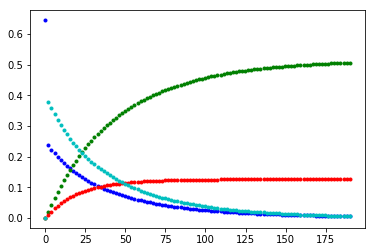

In [5]:
plt.plot(times, A, 'b.',
       times, D, 'g.',
       times, U, 'r.',
       times, B, 'c.')

## Compare
Compare to the experimental results below.

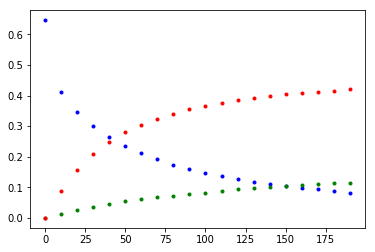

In [6]:
plt.plot(exp.Time.values[:-1], exp.A.values[:-1], 'b.',
       exp.Time.values[:-1], exp.D.values[:-1], 'g.',
       exp.Time.values[:-1], exp.U.values[:-1], 'r.')

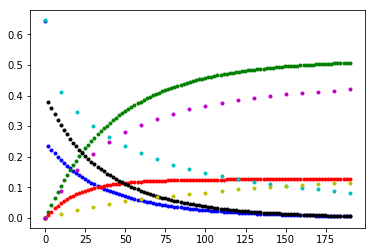

In [7]:
# Plot experimental and calculated results on the same chart
plt.plot(times, A, 'b.',
       times, D, 'g.',
       times, U, 'r.',
         times, B, 'k.',
       exp.Time.values[:-1], exp.A.values[:-1], 'c.',
       exp.Time.values[:-1], exp.D.values[:-1], 'y.',
       exp.Time.values[:-1], exp.U.values[:-1], 'm.')

## Parameters of interest

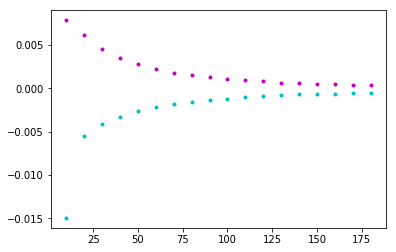

In [8]:
# 3-point differentiation of experimental [A] and [U]
exp_a = exp.A.values[:-1] # ignore the last long-time value
exp_u = exp.U.values[:-1] # ignore the last long-time value
exp_t = exp.Time.values[:-1] # ignore the last long-time value
delta_t = exp_t[1] - exp_t[0]
exp_ra = (np.diff(exp_a[:-1]) + np.diff(exp_a[1:])) / (2 * delta_t)
exp_ru = (np.diff(exp_u[:-1]) + np.diff(exp_u[1:])) / (2 * delta_t)

plt.plot(exp_t[1:-1], exp_ru, 'm.', exp_t[1:-1], exp_ra, 'c.')

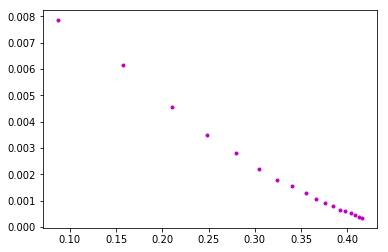

In [9]:
plt.plot(exp_u[1:-1], exp_ru, 'm.')

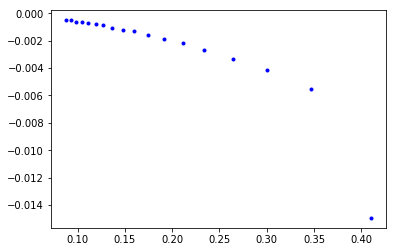

In [10]:
plt.plot(exp_a[1:-1], exp_ra, 'b.')

In [14]:
# use a rough parameter optimization to find k2 at the experiment temperature
# at about 125 seconds U should equal A
#from scipy.optimize import fsolve
def objective(k3_trial):
    t, a, d, u, b = concentrations(init.A, init.C, init.T, t_prefinal, (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3_trial))
    diff = a[15] - u[15]
    return diff

In [16]:
initial_guess = [2.364]
result = optimize.minimize(objective, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[ 290.49986753]


In [17]:
guess = 2.364
max_loops = 1000000
while max_loops:
    if abs(objective(guess)) < 0.001:
        print("Found a value!")
        print(guess)
        break
    guess-=0.01
    max_loops-=1

/home/artem/applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Found a value!
-0.19599999999999412


In [11]:
import random as rd
np.random.seed()
rd.seed()
import bisect
import math

In [13]:
exp = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['t', 'Ca', 'Cd', 'Cu'])

In [14]:
ca = np.array(exp.Ca)
cd = np.array(exp.Cd)
cu = np.array(exp.Cu)
cb = ca[0] - ca - cd - cu
print(cb)
delta_t = exp.t[1] - exp.t[0]
exp_ra = (np.diff(ca[:-1]) + np.diff(ca[1:])) / (2 * delta_t)
exp_ru = (np.diff(cu[:-1]) + np.diff(cu[1:])) / (2 * delta_t)
concentrations =np.array([ca[0:19], cb[0:19], cd[0:19], cu[0:19]])

[ 0.     0.136  0.117  0.1    0.088  0.078  0.07   0.064  0.059  0.052
  0.049  0.046  0.042  0.038  0.037  0.033  0.032  0.029  0.029  0.028
 -0.001]


In [15]:
def rate_A(conc, kf, alpha, kr, beta):
    ca = conc[0]
    cb = conc[1]
    return kf ** ca ** alpha - kr *  cb ** beta
def rate_U(cb, k3):
    return k3 * cb

In [16]:
y_data = exp_ra
x_data = concentrations[0:2]

popt, pcov = optimize.curve_fit(rate_A, x_data, y_data)
print(popt)
print(pcov)

optimal_parameters = popt
parameter_errors = np.sqrt(np.diag(pcov))

def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))
report(popt, pcov)

[  1.91466569e-08  -1.16502021e-01   1.36558545e-02   6.22357111e-01]
[[  2.44853902e-02  -1.66008011e+05  -2.98813642e-02  -5.21666920e-01]
 [ -1.66008011e+05   1.12978563e+12   2.04087354e+05   3.56611761e+06]
 [ -2.98813642e-02   2.04087354e+05   3.79010286e-02   6.71503321e-01]
 [ -5.21666920e-01   3.56611761e+06   6.71503321e-01   1.20020631e+01]]
Parameter 0: 1.914665688625354e-08 +/- 0.15647808201377722 (1 st. dev.)
Parameter 1: -0.11650202127994276 +/- 1062913.7476011717 (1 st. dev.)
Parameter 2: 0.013655854469300085 +/- 0.19468186499726267 (1 st. dev.)
Parameter 3: 0.6223571108946517 +/- 3.4643993830369118 (1 st. dev.)


/home/artem/applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/artem/applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


In [17]:
# stacking example
stack_rows = np.stack((exp_a, exp_u), 0) # stack along the first axis: exp_a is the first row, exp_u is the second row
stack_cols = np.stack((exp_a, exp_u), -1) # stack along last axis: exp_a is the first column, exp_u is the second column
stack_rows

array([[ 0.646,  0.41 ,  0.347,  0.3  ,  0.264,  0.234,  0.211,  0.191,
         0.174,  0.16 ,  0.148,  0.136,  0.127,  0.119,  0.111,  0.105,
         0.098,  0.093,  0.088,  0.083],
       [ 0.   ,  0.087,  0.157,  0.21 ,  0.248,  0.28 ,  0.304,  0.324,
         0.34 ,  0.355,  0.366,  0.376,  0.384,  0.392,  0.397,  0.404,
         0.408,  0.413,  0.416,  0.42 ]])